## Created by <a href="https://github.com/yunsuxiaozi/">yunsuxiaozi</a>  2024/7/3


#### 曾经有大佬说过,只有多读论文,多看比赛的top solution,才能变得更厉害。

#### 这里我找到了Kaggle的Feature比赛里参赛人数最多的一场比赛,总共有8751支队伍参赛。比赛链接是<a href="https://www.kaggle.com/competitions/santander-customer-transaction-prediction">Santander Customer Transaction Prediction</a>我这次看的开源方案:<a href="https://www.kaggle.com/code/titericz/giba-single-model-public-0-9245-private-0-9234">Giba Single Model</a>,这个开源方案能够在比赛中拿到金牌,并且方案相对简单,所以这里我打算仔细学习一下这个开源方案。

### 1.这里就是导入必要的python库,并固定随机种子,保证模型可以复现。


#### 话说,原作者代码好像没固定随机种子?

In [1]:
import numpy as np#矩阵运算与科学计算的库
import pandas as pd#读取csv文件的库
#model
import lightgbm as lgb#导入lightgbm模型,这是一个集成学习模型
# #KFold是直接分成k折,StratifiedKFold还要考虑每种类别的占比
from sklearn.model_selection import StratifiedKFold
import gc#垃圾回收模块
import warnings#避免一些可以忽略的报错
warnings.filterwarnings('ignore')#filterwarnings()方法是用于设置警告过滤器的方法，它可以控制警告信息的输出方式和级别。

import random#提供了一些用于生成随机数的函数
#设置随机种子,保证模型可以复现
def seed_everything(seed):
    np.random.seed(seed)#numpy的随机种子
    random.seed(seed)#python内置的随机种子
seed_everything(seed=2024)

### 2.读取训练数据和测试数据,看看数据长啥样.

- ID-code:就是数据的编号,没什么用。

- target:就是我们需要预测的目标,这是一个二分类任务,评估指标为roc_auc.

- var:就是200个变量,也就是我们的特征。

In [2]:
#读取训练数据和测试数据
train_df = pd.read_csv("/kaggle/input/santander-customer-transaction-prediction/train.csv")
test_df = pd.read_csv("/kaggle/input/santander-customer-transaction-prediction/test.csv")
train_df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


###  3.特征工程

#### 如果一个变量和target是负相关,那就乘以-1把它变成正相关。由于这是树模型,恕我直言,这个可能没什么用?

In [3]:
#除了target以外的所有特征
features = [x for x in train_df.columns if x.startswith("var")]
#对于变量特征,如果和target的相关性是负相关,则乘-1变成正相关
for var in features:
    if np.corrcoef( train_df['target'], train_df[var] )[1][0] < 0:
        train_df[var] = train_df[var] * -1
        test_df[var]  = test_df[var]  * -1

#### hist_df+遍历特征代码: 统计全体(训练+测试)每个数值在数据中出现的次数,看看测试数据中每个数值在全体的出现次数,如果大于1为True,否则为False.(由于是看测试数据,所以每个数值在测试数据中首先出现了一次,大于1可能是在测试数据中还出现过,也有可能是在训练数据出现过)最后得到的hist_df是和测试数据同样大小,看每个测试数据每行的每个数值在全体数据中出现是否大于1次的True False表。

#### ind:就是看每行是否都是True,都是True的话就等于200,不等于200就意味着测试集这行某列有数据是全体数据这列唯一一次的数据,这些数据是在训练集中绝对没有出现过的。

In [4]:
hist_df = pd.DataFrame()
for var in features:
    #统计训练数据和测试数据total_df var列每个值出现的次数
    var_stats = pd.concat((train_df[var],test_df[var])).value_counts()
    #测试集出现的值和出现次数的映射
    hist_df[var] = pd.Series(test_df[var]).map(var_stats)
    #最后判断一下var这列的值是否大于1
    hist_df[var] = (hist_df[var] > 1)
    
#测试数据某行的是否有var的值在训练数据中没有出现,在测试数据只出现一次
ind = (hist_df.sum(axis=1) != 200)

#### 把训练集和训练集中没出现(因为在全体数据中出现一次)的数据一起做一个value_count()。

In [5]:
#某列var 最终的value_counts统计
var_stats = {}
for var in features:
    #训练数据和测试数据中存在特有的只出现一次index进行value_counts统计.
    var_stats[var] = pd.concat((train_df[var],test_df[ind][var])).value_counts()

#### 这是一个函数,传入的是变量vr,变量的value_count():var_stats,和这是第几个变量feat_id。得到的是变量自身,变量的count,变量的id,归一化后的变量排名。

In [6]:
#变量自身,变量的count,第几个变量,归一化后变量的排名
def var_to_feat(vr, var_stats, feat_id ):
    #创建新的表格
    new_df = pd.DataFrame()
    #传入的train_df[var].values
    new_df["var"] = vr.values
    #vr对应的count
    new_df["hist"] = pd.Series(vr).map(var_stats)
    #第几个变量
    new_df["feature_id"] = feat_id
    #归一化后的变量排名
    new_df["var_rank"] = new_df["var"].rank()/len(vr)
    return new_df.values

#### 比赛有200个var和target,他这里选择用var_0构造的4个特征预测target,var_1构造的4个特征预测target,……所以实际上他有了200倍的训练数据。

In [7]:
#var_0构造特征和target,var_1构造特征和target,……搞了200倍的数据

#就是把训练数据的target*200
TARGET = np.array( list(train_df['target'].values) * 200 )
TRAIN = []
var_mean = {}
var_var  = {}
for var in features:
    #train_df[var]是数据,var_stats[var]是value_counts统计,'var_0':第几个变量
    tmp = var_to_feat(train_df[var], var_stats[var], int(var[4:]) )
    #变量本身的均值,方差
    var_mean[var],var_var[var] = np.mean(tmp[:,0]),np.var(tmp[:,0])
    #归一化后的数值
    tmp[:,0] = (tmp[:,0]-var_mean[var])/var_var[var]
    #训练数据
    TRAIN.append( tmp )
TRAIN = np.vstack( TRAIN )

#清理数据
del train_df
gc.collect()
print(f"TRAIN.shape:{TRAIN.shape},len(TARGET):{len(TARGET)}")

TRAIN.shape:(40000000, 4),len(TARGET):40000000


### 4.模型的训练

#### 模型的训练过程很常规,这里没什么好说的。

In [8]:
#模型的训练很常规,就不看了
model = lgb.LGBMClassifier(**{
     'learning_rate': 0.04,
     'num_leaves': 31,
     'max_bin': 1023,
     'min_child_samples': 1000,
     'reg_alpha': 0.1,
     'reg_lambda': 0.2,
     'feature_fraction': 1.0,
     'bagging_freq': 1,
     'bagging_fraction': 0.85,
     'objective': 'binary',
     'n_jobs': -1,
     'n_estimators':120,
     "verbose": -1
})
MODELS = []
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=2024)
for fold, (train_indexes, valid_indexes) in enumerate(skf.split(TRAIN, TARGET)):
    print('Fold:', fold )
    model = model.fit( TRAIN[train_indexes], TARGET[train_indexes],
                      eval_set = (TRAIN[valid_indexes], TARGET[valid_indexes]),
                      eval_metric='auc',
                      categorical_feature = [2] )
    MODELS.append( model )
del TRAIN, TARGET
gc.collect()

Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 5
Fold: 6
Fold: 7
Fold: 8
Fold: 9


163

### 5.推理与提交。

#### 测试数据的处理和训练数据一样,对预测结果求均值也很常规,它这里主要有2点是常规代码里没有的。

- rank():这个rank/len(test)不会改变数据的大小顺序,因为本来就是按照大小来rank的,这里的目的是为了将预测的概率归一化到0到1之间,那么之前是什么操作让预测的概率脱离了0到1的范围呢?就是logit。logit(0.9999)=9.21,logit(0.0001)为-9.21,所以rank这个操作是为logit服务的,那么为什么要用logit呢?

- logit():仔细观察logit函数就会发现它是一个单调递增的函数,同时以0.5呈现中心对称。我觉得可能和logit的斜率有关,y=x的斜率是固定的。logit函数在概率靠近0.5的时候平一点,因为模型对这个样本没有把握,logit在概率为0.9和0.1的时候斜率很大,是因为此时模型很自信,如果是y=x,概率0.9和概率0.8时模型增加的自信是0.1,实际上模型自信的时候就应该把这种自信从数值上放大,表现更加明显。

In [9]:
#单调递增
def logit(p):
    return np.log(p) - np.log(1 - p)
ypred = np.zeros( (200000,200) )
for idx,var in enumerate(features):
    #构造测试数据
    tmp = var_to_feat(test_df[var], var_stats[var], int(var[4:]) )
    tmp[:,0] = (tmp[:,0]-var_mean[var])/var_var[var]
    for model_id in range(len(MODELS)):
        model = MODELS[model_id]
        ypred[:,idx] += model.predict_proba( tmp )[:,1] /len(MODELS)
ypred = np.mean( logit(ypred), axis=1 )

submission = test_df[['ID_code']]
submission['target'] = ypred
submission['target'] = submission['target'].rank() / len(test_df)
submission.to_csv('golden_submission.csv', index=False)
submission.head()

,ID_code,target
0,test_0,0.789345
1,test_1,0.869480
2,test_2,0.873440
3,test_3,0.859170
4,test_4,0.753845


### 6.作图

#### 这里作了logit函数的图像,简单看看。

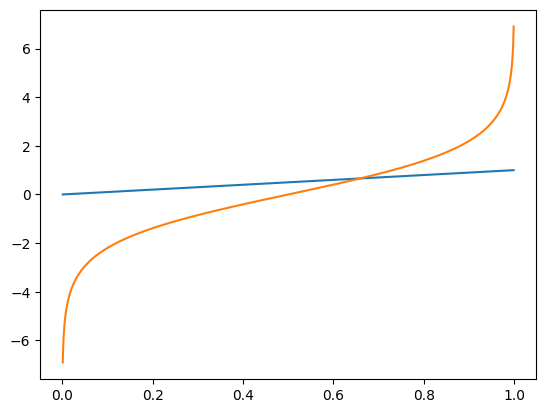

In [10]:
import matplotlib.pyplot as plt#强大的绘图库
X=[i/1000 for i in range(1,1000)]
y=np.array([logit(X[i]) for i in range(len(X))])
plt.plot(X,X)
plt.plot(X,y)
plt.show()